In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from math import*
from pandas.io.parsers.readers import read_csv

In [540]:
import copy
from graphviz import Digraph

In [541]:
## Variables ##

dataset='tennis'
split_func='IG'



In [542]:
datasets={'tennis':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/data.csv','PlayTennis'],'cars':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/car.csv','class'],'lenses':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/lenses.csv','Class'],'chess':['https://raw.githubusercontent.com/Kvnpsiddhartha/DecisionTreeImplementation/main/kr-vs-kp.csv','result']}

In [543]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [544]:
print(data)

     Outlook Temperature Humidity    wind PlayTennis
0      sunny         hot     high    weak         no
1      sunny         hot     high  strong         no
2   overcast         hot     high    weak        yes
3       rain        mild     high    weak        yes
4       rain        cool   normal    weak        yes
5       rain        cool   normal  strong         no
6   overcast        cool   normal  strong        yes
7      sunny        mild     high    weak         no
8      sunny        cool   normal    weak        yes
9       rain        mild   normal    weak        yes
10     sunny        mild   normal  strong        yes
11  overcast        mild     high  strong        yes
12  overcast         hot   normal    weak        yes
13      rain        mild     high  strong         no


In [545]:
data

,Outlook,Temperature,Humidity,wind,PlayTennis
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes
5,rain,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rain,mild,normal,weak,yes


In [546]:
print(pd.DataFrame(data))
df=pd.DataFrame(data)
df.dtypes

     Outlook Temperature Humidity    wind PlayTennis
0      sunny         hot     high    weak         no
1      sunny         hot     high  strong         no
2   overcast         hot     high    weak        yes
3       rain        mild     high    weak        yes
4       rain        cool   normal    weak        yes
5       rain        cool   normal  strong         no
6   overcast        cool   normal  strong        yes
7      sunny        mild     high    weak         no
8      sunny        cool   normal    weak        yes
9       rain        mild   normal    weak        yes
10     sunny        mild   normal  strong        yes
11  overcast        mild     high  strong        yes
12  overcast         hot   normal    weak        yes
13      rain        mild     high  strong         no


Outlook        object
Temperature    object
Humidity       object
wind           object
PlayTennis     object
dtype: object

In [547]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

Outlook        14
Temperature    14
Humidity       14
wind           14
PlayTennis     14
dtype: int64
14


In [548]:
import random
def train_test_split(df,test_size):
  df=df.sample(frac = 1)
  n=len(df)
  no_test_rows=int(n*test_size)
  l=list(random.sample(list(range(n)), no_test_rows))
  test=df.iloc[l]
  train=df.drop(l,axis=0)
  return train.sample(frac = 1),test.sample(frac = 1)
# test_df=data
df,test_df=train_test_split(df,0.3)
print(len(df),len(test_df))

# from sklearn.model_selection import train_test_split
# df,test_df=test_train_split(df,test_size=0.3)

10 4


In [549]:
class DecisionTree():
  
  ## Class Member Functions ##

  def entropy_help(p):
    return -p*log(p,2)
  
  def getEntropy(df,target_name):  
    n=df.count()[0]
    target_counts=df[target_name].value_counts().to_dict()
    s=0
    for p in target_counts.values():
      if p/n==1 or p/n==0:
        return 0
      s+=DecisionTree.entropy_help(p/n)
    return s
  
  def getProbability(df,column,value):
    return df[df[column]==value].count()[0]/df.count()[0]
  
  def informationGain(df,target_name,col):
    total_entropy=DecisionTree.getEntropy(df,target_name)
    col_vals_count=df[col].value_counts().to_dict()
    sum=0
    for value in col_vals_count:
      n=col_vals_count[value]
      sum+=(DecisionTree.getEntropy(df[df[col]==value],target_name)*DecisionTree.getProbability(df,col,value))
    return total_entropy-sum

  ## Class Data Members ##

  split_functions={'IG':informationGain}
  
  ## Countructor ##
  def __init__(self,df,target_name,split_function="IG"):
    self.tree=self.Tree()
    self.df=df
    self.target_name=target_name
    self.cols=list(self.df.columns)
    self.cols.remove(self.target_name)
    self.cnt=0
    self.gnodes=[]
    self.output_classes=self.df[self.target_name].unique()
    if split_function in DecisionTree.split_functions:
      self.split_function=DecisionTree.split_functions[split_function]
    else:
      raise Exception("Split function not found")

  ## Instance Methods ##

  def getGraph(self):
    return self.tree.g

  def find_leaf(self,df):
      unique_vals=list(df[self.target_name].unique())
      for val in unique_vals:      
        if df[df[self.target_name]==val].count()[0]==df.count()[0]:
          return val

  def construct(self):
    maxig=[-1,""]
    for i in self.cols:
      etemp=self.split_function(df,self.target_name,i)
      maxig=maxig if maxig[0]>etemp else [etemp,i]
    root=self.Node(maxig[1],maxig[0],0)
    self.tree.insert_root(root)
    c=copy.deepcopy(self.cols)
    c.remove(root.name)
    self.gnodes.append(root)
    root.gname=str(root)
    self.tree.g.node(str(root),str(root))
    self.construct_help(df,c,root)

  def construct_help(self,df,cols,parent):
    vals=list(df[parent.name].unique())
    dftemp=df

    for k in vals:
      df=dftemp
      df=df[df[parent.name]==k]
      e=DecisionTree.getEntropy(df,self.target_name)

      if e==0:
        value=self.find_leaf(df)
        node=self.Node(value,1,parent.level+1)
        node.gname=str(value)
        parent.insert_child(node)
        parent.insert_edge(k)
        self.tree.no_leafs+=1
        name=value
        if not isinstance(value, str):
          name='class'
        self.tree.g.node(name+str(self.cnt),str(value))
        self.tree.g.edge(str(parent.gname),name+str(self.cnt),label=str(k))
        
        self.cnt+=1
        continue
      maxig=[-1,""]
      for i in cols:
        etemp=self.split_function(df,self.target_name,i)
        maxig=maxig if maxig[0]>etemp else [etemp,i]
      node=self.Node(maxig[1],maxig[0],parent.level+1)
      node.gname=str(node.name)
      c=copy.deepcopy(cols)
      
      c.remove(node.name)
      name=str(node)
      if name in self.gnodes:
        name+=str(self.cnt)
        self.cnt+=1
      else:
        self.gnodes.append(name)
      node.gname=name
      self.tree.g.node(name,str(node))
      parent.insert_child(node)
      parent.insert_edge(k)
      self.tree.g.edge(str(parent.gname),name,label=str(k))
      self.construct_help(df[df[parent.name]==k],c,node)
      
  def predict(self,instances,trace=False):
    node=self.tree.root
    op=[]
    if isinstance(instances,dict):
      return self.predict_help(node,instances,trace,"")
    if isinstance(instances,list):
      
      for instance in instances:
        op.append(self.predict_help(node,instance,trace,""))
    else:
      n=len(instances)
      for i in range(n):
        instance=data.iloc[i].to_dict()
        op.append(self.predict_help(node,instance,trace,""))
    return op

  def predict_help(self,node,instance,trace,path):
    if node.name in self.output_classes:
      if trace:
        print(path+str(node))
      return node.name
    value=instance[node.name]
    try:
      path+=str(node)+" ( "+str(value)+" ) ->"
      ind=node.edges.index(value)
      return self.predict_help(node.childs[ind],instance,trace,path)
    except Exception as e:
      return "Not valid instance, path: "+path
  
  ## Inner classes ##
  class Node:
    ## Countructor ##
    def __init__(self,name,ig,level):
      self.name=name
      self.ig=ig
      self.childs=[]
      self.edges=[]
      self.gname=''
      self.level=level

    ## Instance Methods ##

    def insert_child(self,node):
      self.childs.append(node)

    def insert_edge(self,edge):
      self.edges.append(edge)

    def printn(self,edge=""):
      # if self.childs:
      dashes="|"+"-"*(self.level*5)
      value="( "+edge+") "+self.gname if edge else self.gname
      # print(" "*(self.level*2+1),''.join(['-']*31))
      # print(dashes,'|{:^15} - level - {:^2} | '.format(self.gname,self.level),list(zip(self.edges,list(map(lambda x:x.gname,self.childs)))))
      # print(" "*(self.level*2+1),''.join(['-']*31))
      print(dashes,value)

    def __str__(self):
      return str(self.name)

  class Tree:

    ## Countructor ##
    def __init__(self):
      self.root=None
      self.g=Digraph(encoding='utf-8')
      self.no_leafs=0

    ## Instance Methods ##

    def insert_root(self,node):
      self.root=node

    def printt(self):
      self.print_help(self.root,"")

    def print_help(self,node,edge):
      if node:
        node.printn(edge)
        # print("(",edge,")")
      for i in range(len(node.childs)):
        self.print_help(node.childs[i],node.edges[i])

In [550]:
d=DecisionTree(data,target_name,split_function=split_func)

In [551]:
d.construct()

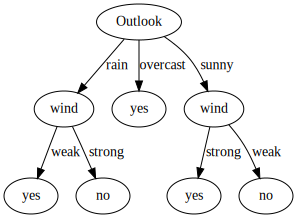

In [552]:
d.getGraph()

In [553]:
print(d.tree.no_leafs)

5


In [554]:
inp=[]
n=1000
n=n if n < len(test_df) else len(test_df)
for i in range(n):
  inp.append(test_df.iloc[i].to_dict())
print(d.predict(inp))

['yes', 'yes', 'yes', 'yes']


In [555]:
d.tree.printt()

| Outlook
|----- ( rain) wind
|---------- ( weak) yes
|---------- ( strong) no
|----- ( overcast) yes
|----- ( sunny) wind3
|---------- ( strong) yes
|---------- ( weak) no


In [556]:
o=list(enumerate(d.predict(data)))
o

[(0, 'no'),
 (1, 'yes'),
 (2, 'yes'),
 (3, 'yes'),
 (4, 'yes'),
 (5, 'no'),
 (6, 'yes'),
 (7, 'no'),
 (8, 'no'),
 (9, 'yes'),
 (10, 'yes'),
 (11, 'yes'),
 (12, 'yes'),
 (13, 'no')]

In [557]:
data[target_name]

0      no
1      no
2     yes
3     yes
4     yes
5      no
6     yes
7      no
8     yes
9     yes
10    yes
11    yes
12    yes
13     no
Name: PlayTennis, dtype: object

In [558]:
count=0
for i in o:
  if i[1]=='Not valid instance':
    print("Something went wrong")
    count+=1
print(count)

0


In [559]:
print(df.iloc[0].to_dict())
d.predict(df.iloc[0].to_dict(),trace=True)

{'Outlook': 'rain', 'Temperature': 'mild', 'Humidity': 'high', 'wind': 'weak', 'PlayTennis': 'yes'}
Outlook ( rain ) ->wind ( weak ) ->yes


'yes'